# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Check GPU
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(1))

2
NVIDIA GeForce RTX 3090


# Part C 

## Implement Custom Resnet + Layer Normalization

In [3]:
class CustomResNet_LN(nn.Module):
    def __init__(self):
        super(CustomResNet_LN, self).__init__()

        # Initial layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.norm1 = nn.LayerNorm([32, 32, 32])  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.norm2 = nn.LayerNorm([64, 32, 32])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Residual block 1
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.norm3 = nn.LayerNorm([64, 16, 16])
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.norm4 = nn.LayerNorm([64, 16, 16])
        self.match_conv1 = nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0)

        # Residual block 2
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.norm5 = nn.LayerNorm([128, 16, 16])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.match_conv2 = nn.Conv2d(64, 128, kernel_size=1, stride=2, padding=0)

        # Residual block 3
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.norm6 = nn.LayerNorm([256, 8, 8])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.norm7 = nn.LayerNorm([256, 4, 4])
        self.match_conv3 = nn.Conv2d(128, 256, kernel_size=1, stride=2, padding=0)

        # Final layers
        self.avg_pool = nn.AvgPool2d(kernel_size=3)
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.elu(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = F.elu(x)
        x = self.pool1(x)

        # Residual block 1
        identity = x
        x = self.conv3(x)
        x = self.norm3(x)
        x = F.elu(x)
        x = self.conv4(x)
        x = self.norm4(x)
        x += identity
        x = F.elu(x)

        # Residual block 2
        identity = self.match_conv2(x)  # Adjust dimensions of identity
        x = self.conv5(x)
        x = self.norm5(x)
        x = F.elu(x)
        x = self.pool2(x)
        x += identity
        x = F.elu(x)

        # Residual block 3
        identity = self.match_conv3(x)  # Adjust dimensions of identity
        x = self.conv6(x)
        x = self.norm6(x)
        x = F.elu(x)
        x = self.pool3(x)
        x = self.conv7(x)
        x = self.norm7(x)
        x += identity
        x = F.elu(x)

        # Final layers
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.elu(self.fc1(x))
        x = self.fc2(x)

        return x


## Load Dataset

In [4]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# # Data augmentation and normalization for training
# transform_train = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Optimizer and Train Setup

In [6]:
# Model, optimizer, and scheduler
model = CustomResNet_LN()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=40, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [7]:
# Determine if CUDA is available and set the device accordingly
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomResNet_LN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): LayerNorm((32, 32, 32), eps=1e-05, elementwise_affine=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): LayerNorm((64, 32, 32), eps=1e-05, elementwise_affine=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): LayerNorm((64, 16, 16), eps=1e-05, elementwise_affine=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): LayerNorm((64, 16, 16), eps=1e-05, elementwise_affine=True)
  (match_conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm5): LayerNorm((128, 16, 16), eps=1e-05, elementwise_affine=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (

In [8]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# Training loop with tracking of training and validation accuracies
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
best_val_accuracy = 0
best_model_weights = None


In [9]:
for epoch in range(1, 61):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer , criterion)
    val_loss, val_accuracy = test(model, device, val_loader , criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = model.state_dict()

    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    scheduler.step()

Epoch: 1, Train Loss: 1.7068, Train Accuracy: 36.62%, Val Loss: 1.4507, Val Accuracy: 46.02%
Epoch: 2, Train Loss: 1.3409, Train Accuracy: 51.35%, Val Loss: 1.2003, Val Accuracy: 56.20%
Epoch: 3, Train Loss: 1.1277, Train Accuracy: 59.32%, Val Loss: 1.0883, Val Accuracy: 61.26%
Epoch: 4, Train Loss: 0.9952, Train Accuracy: 64.72%, Val Loss: 1.0143, Val Accuracy: 64.30%
Epoch: 5, Train Loss: 0.8929, Train Accuracy: 68.62%, Val Loss: 0.9075, Val Accuracy: 68.36%
Epoch: 6, Train Loss: 0.8193, Train Accuracy: 71.02%, Val Loss: 0.8187, Val Accuracy: 71.14%
Epoch: 7, Train Loss: 0.7537, Train Accuracy: 73.56%, Val Loss: 0.7443, Val Accuracy: 73.58%
Epoch: 8, Train Loss: 0.7045, Train Accuracy: 75.43%, Val Loss: 0.7606, Val Accuracy: 73.22%
Epoch: 9, Train Loss: 0.6611, Train Accuracy: 76.82%, Val Loss: 0.7178, Val Accuracy: 74.96%
Epoch: 10, Train Loss: 0.6420, Train Accuracy: 77.54%, Val Loss: 0.6676, Val Accuracy: 76.20%
Epoch: 11, Train Loss: 0.6084, Train Accuracy: 78.61%, Val Loss: 0.70

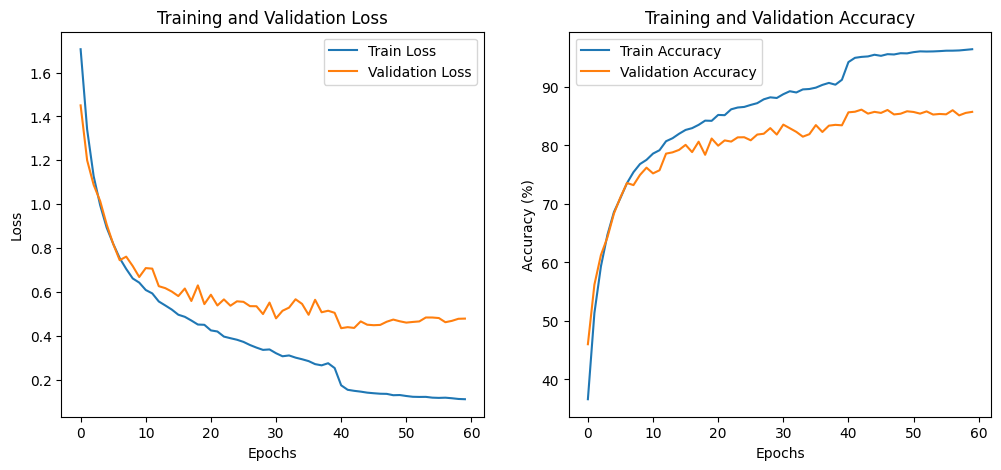

Best Validation Accuracy: 86.12%
Test Accuracy of the final model: 86.25%


In [11]:
# Load best model weights and evaluate on test set
model.load_state_dict(best_model_weights)
test_loss, test_accuracy = test(model, device, test_loader , criterion)

# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Print best validation accuracy and test accuracy
print(f'Best Validation Accuracy: {best_val_accuracy:.2f}%')
print(f'Test Accuracy of the final model: {test_accuracy:.2f}%')

# Save best model weights
torch.save(best_model_weights, 'best_custom_resnet_weights_LN.pth')

# Layer Wise analyse , Part A

In [ ]:
# download Pretrained Weight of model
import gdown
id = "1tDtBl-yh6DY5hOmfFRFaf1nWqMZP89LD"
gdown.download(id=id, quiet=False)

In [ ]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

In [3]:
from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex

In [4]:
class CustomResNet_LN(nn.Module):
    def __init__(self):
        super(CustomResNet_LN, self).__init__()

        # Initial layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.norm1 = nn.LayerNorm([32, 32, 32])  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.norm2 = nn.LayerNorm([64, 32, 32])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Residual block 1
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.norm3 = nn.LayerNorm([64, 16, 16])
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.norm4 = nn.LayerNorm([64, 16, 16])
        self.match_conv1 = nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0)

        # Residual block 2
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.norm5 = nn.LayerNorm([128, 16, 16])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.match_conv2 = nn.Conv2d(64, 128, kernel_size=1, stride=2, padding=0)

        # Residual block 3
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.norm6 = nn.LayerNorm([256, 8, 8])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.norm7 = nn.LayerNorm([256, 4, 4])
        self.match_conv3 = nn.Conv2d(128, 256, kernel_size=1, stride=2, padding=0)

        # Final layers
        self.avg_pool = nn.AvgPool2d(kernel_size=3)
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.elu(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = F.elu(x)
        x = self.pool1(x)

        # Residual block 1
        identity = x
        x = self.conv3(x)
        x = self.norm3(x)
        x = F.elu(x)
        x = self.conv4(x)
        x = self.norm4(x)
        x += identity
        x = F.elu(x)

        # Residual block 2
        identity = self.match_conv2(x)  # Adjust dimensions of identity
        x = self.conv5(x)
        x = self.norm5(x)
        x = F.elu(x)
        x = self.pool2(x)
        x += identity
        x = F.elu(x)

        # Residual block 3
        identity = self.match_conv3(x)  # Adjust dimensions of identity
        x = self.conv6(x)
        x = self.norm6(x)
        x = F.elu(x)
        x = self.pool3(x)
        x = self.conv7(x)
        x = self.norm7(x)
        x += identity
        x = F.elu(x)

        # Final layers
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.elu(self.fc1(x))
        x = self.fc2(x)

        return x


In [5]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


# Further split train_dataset into train_loader_dataset and 20% balanced subset
train_loader_dataset, _ = train_test_split(train_dataset.dataset, train_size=int(0.2 * len(train_dataset)),
                                           test_size=None, shuffle=True, stratify=train_dataset.dataset.targets)

# Data loaders
train_loader = DataLoader(train_loader_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Instantiate and load the model
model = CustomResNet_LN()  # Make sure CustomResNet is defined as earlier
model.load_state_dict(torch.load('best_custom_resnet_weights_LN.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

CustomResNet_LN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): LayerNorm((32, 32, 32), eps=1e-05, elementwise_affine=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): LayerNorm((64, 32, 32), eps=1e-05, elementwise_affine=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): LayerNorm((64, 16, 16), eps=1e-05, elementwise_affine=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): LayerNorm((64, 16, 16), eps=1e-05, elementwise_affine=True)
  (match_conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm5): LayerNorm((128, 16, 16), eps=1e-05, elementwise_affine=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (

In [8]:
# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'match_conv1', 'match_conv2', 'match_conv3', 'fc1', 'fc2'}

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

## SI and CenterSI layer for Train Loader

In [19]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 36/36 [00:00<00:00, 84.37it/s] 


### Calc SI

In [20]:
si_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_train.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 337.16it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6452.78it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7182.03it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6668.21it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6937.32it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7492.50it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7487.15it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7684.69it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7376.55it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6121.28it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6958.04it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6626.07it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6458.74it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7423.55it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7314.80it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7030.35it/s]

Data has been normalized



Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7219.11it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6576.21it/s]


In [21]:
si_layer_train

[('conv1', 0.22822222113609314),
 ('norm1', 0.27433332800865173),
 ('conv2', 0.26322221755981445),
 ('norm2', 0.3771111071109772),
 ('pool1', 0.4664444625377655),
 ('conv3', 0.5139999985694885),
 ('norm3', 0.5695555806159973),
 ('conv4', 0.5878888964653015),
 ('norm4', 0.5684444308280945),
 ('conv5', 0.5429999828338623),
 ('norm5', 0.6013333201408386),
 ('pool2', 0.6155555844306946),
 ('conv6', 0.6809999942779541),
 ('norm6', 0.6752222180366516),
 ('pool3', 0.701888918876648),
 ('conv7', 0.7910000085830688),
 ('norm7', 0.7817777991294861),
 ('avg_pool', 0.8814444541931152)]

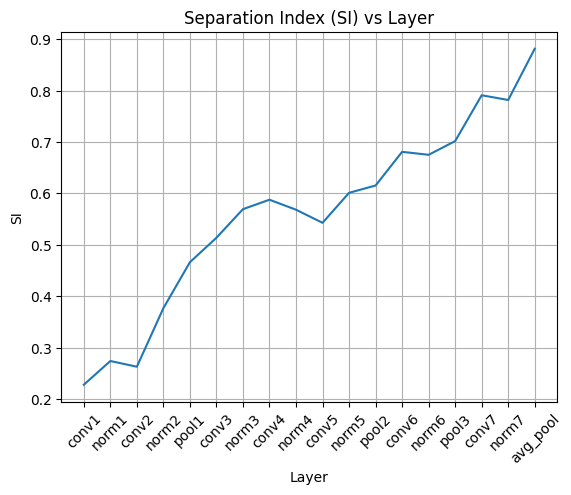

In [22]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_train], [si for _, si in si_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center Si

In [23]:
csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 844.64it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4088.02it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3929.46it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4185.93it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2965.01it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3233.35it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3038.47it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3263.03it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3096.80it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4186.77it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4221.32it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3811.62it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3311.99it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3248.38it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3753.63it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4116.10it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4022.16it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2802.18it/s]


[('conv1', 0.3534444570541382), ('norm1', 0.35822221636772156), ('conv2', 0.3691111207008362), ('norm2', 0.3758888840675354), ('pool1', 0.4463333487510681), ('conv3', 0.5408889055252075), ('norm3', 0.5533333420753479), ('conv4', 0.5678889155387878), ('norm4', 0.5643333196640015), ('conv5', 0.5812222361564636), ('norm5', 0.5816666483879089), ('pool2', 0.5902222394943237), ('conv6', 0.6517778038978577), ('norm6', 0.6551111340522766), ('pool3', 0.6993333697319031), ('conv7', 0.8121111392974854), ('norm7', 0.7934444546699524), ('avg_pool', 0.8974444270133972)]


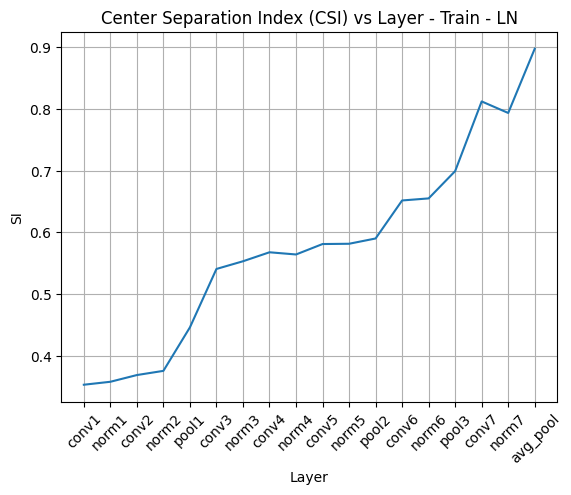

In [24]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - Train - LN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Val Loader

In [8]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(val_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 20/20 [00:00<00:00, 22.30it/s]


### Calc SI

In [9]:
si_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_val.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 214.32it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4583.94it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4660.34it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5461.33it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4650.00it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5444.79it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5096.36it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5345.33it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5966.29it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5027.13it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5216.80it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5758.77it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5416.66it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5123.34it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5557.82it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4915.20it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5190.97it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4660.34it/s]


In [10]:
si_layer_val

[('conv1', 0.21779999136924744),
 ('norm1', 0.25),
 ('conv2', 0.21799999475479126),
 ('norm2', 0.33059999346733093),
 ('pool1', 0.4156000018119812),
 ('conv3', 0.45659998059272766),
 ('norm3', 0.515999972820282),
 ('conv4', 0.5388000011444092),
 ('norm4', 0.5076000094413757),
 ('conv5', 0.48559999465942383),
 ('norm5', 0.5523999929428101),
 ('pool2', 0.5667999982833862),
 ('conv6', 0.6345999836921692),
 ('norm6', 0.6363999843597412),
 ('pool3', 0.6779999732971191),
 ('conv7', 0.7635999917984009),
 ('norm7', 0.7486000061035156),
 ('avg_pool', 0.8578000068664551)]

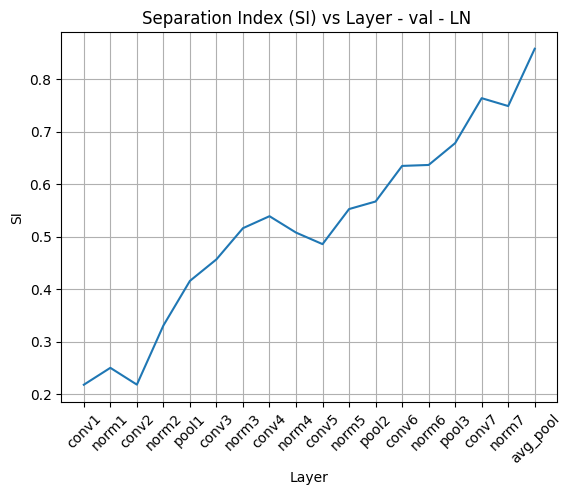

In [11]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_val], [si for _, si in si_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - val - LN ')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### calc Center SI

In [12]:
csi_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_val.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 456.42it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3061.54it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3072.75it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3456.84it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3008.83it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3302.60it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3398.95it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3260.67it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3169.50it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3368.02it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3239.68it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3048.92it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3248.04it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3370.72it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2846.81it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2901.96it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3385.23it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2010.05it/s]


[('conv1', 0.3497999906539917), ('norm1', 0.36139997839927673), ('conv2', 0.3700000047683716), ('norm2', 0.3773999810218811), ('pool1', 0.4355999827384949), ('conv3', 0.5299999713897705), ('norm3', 0.5437999963760376), ('conv4', 0.5651999711990356), ('norm4', 0.5577999949455261), ('conv5', 0.5805999636650085), ('norm5', 0.5794000029563904), ('pool2', 0.5925999879837036), ('conv6', 0.6615999937057495), ('norm6', 0.6631999611854553), ('pool3', 0.7080000042915344), ('conv7', 0.812999963760376), ('norm7', 0.7961999773979187), ('avg_pool', 0.9007999897003174)]


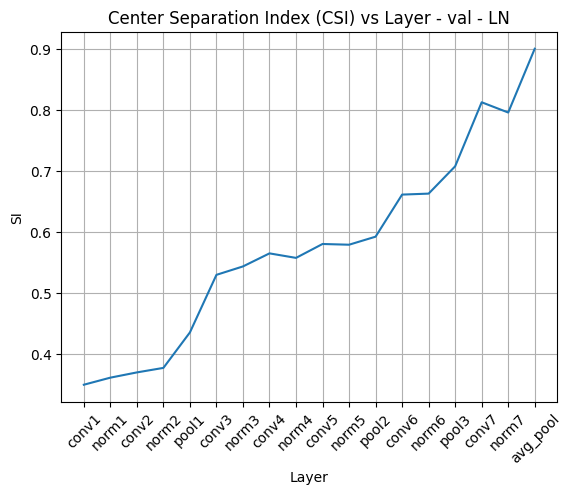

In [13]:
print(csi_layer_val)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_val], [si for _, si in csi_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - val - LN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Test Loader

In [9]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 40/40 [00:01<00:00, 26.48it/s]


### Calc SI

In [10]:
si_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_test.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 368.06it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7299.52it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6488.71it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6490.72it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7741.42it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7089.76it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6741.09it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6570.03it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7407.81it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7854.50it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7931.74it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6873.65it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7276.72it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6844.49it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7106.58it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7152.63it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7761.48it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7384.34it/s]


In [11]:
si_layer_test

[('conv1', 0.22839999198913574),
 ('norm1', 0.2807999849319458),
 ('conv2', 0.2572999894618988),
 ('norm2', 0.37289997935295105),
 ('pool1', 0.46309998631477356),
 ('conv3', 0.5080000162124634),
 ('norm3', 0.5619999766349792),
 ('conv4', 0.5817999839782715),
 ('norm4', 0.5546000003814697),
 ('conv5', 0.5235999822616577),
 ('norm5', 0.5877999663352966),
 ('pool2', 0.6017000079154968),
 ('conv6', 0.6588000059127808),
 ('norm6', 0.6596999764442444),
 ('pool3', 0.6890000104904175),
 ('conv7', 0.7421000003814697),
 ('norm7', 0.7493000030517578),
 ('avg_pool', 0.7724999785423279)]

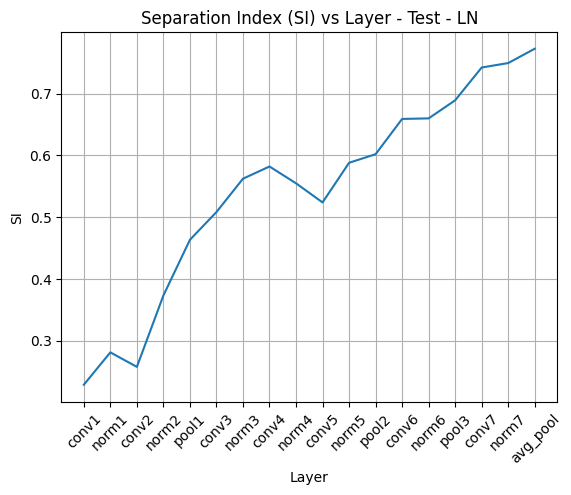

In [12]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_test], [si for _, si in si_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - Test - LN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center SI

In [13]:
csi_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_test.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 917.79it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4758.68it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4218.77it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4326.70it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3190.56it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3277.31it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3370.00it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3299.48it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3258.98it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4894.17it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 5020.71it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3894.43it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3476.13it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3344.74it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4223.87it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4065.04it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4549.14it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4377.27it/s]


[('conv1', 0.3513000011444092), ('norm1', 0.36489999294281006), ('conv2', 0.3739999830722809), ('norm2', 0.37929999828338623), ('pool1', 0.435699999332428), ('conv3', 0.5270000100135803), ('norm3', 0.5385000109672546), ('conv4', 0.5564000010490417), ('norm4', 0.5516999959945679), ('conv5', 0.5719999670982361), ('norm5', 0.5690000057220459), ('pool2', 0.5781999826431274), ('conv6', 0.6456999778747559), ('norm6', 0.6520999670028687), ('pool3', 0.684499979019165), ('conv7', 0.7597000002861023), ('norm7', 0.7495999932289124), ('avg_pool', 0.8162999749183655)]


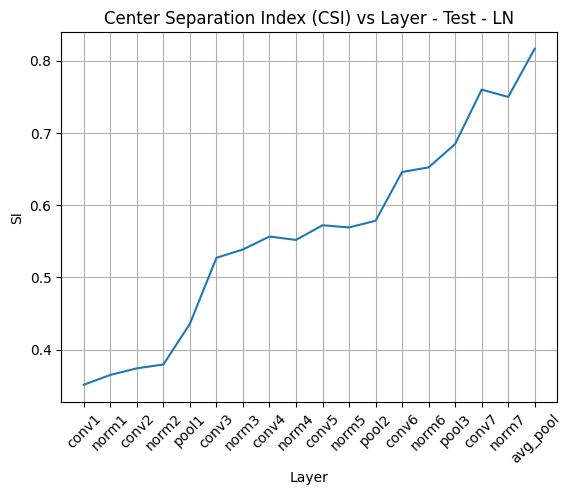

In [14]:
print(csi_layer_test)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_test], [si for _, si in csi_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - Test - LN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()